# Robot Move Time Estimation

Final project for EE_475
Qingyuan Chen

The source code is available at: https://github.com/Gray-Stone/robotarm-movetime-guess

A video presentation is available at: https://www.youtube.com/watch?v=Z4QHAidZAkUT

## Background
Any robot's motion is constrained by its dynamic model. Specially its maximum motion speed is constrained by the dynamic model which depends on its own configuration. The dynamic model can be constructed if knowing all physical property of a robot, which then can be used to generate time-optimized trajectory. 

In the case of an industrial robot arm, these calculation are all done with its own controller. The controller always able to generate a best optimized trajectory utilizing the arm to its limit. However the parameters for constructing dynamic model itself is always regarded as trade secrets.

When using such industrial robot arm, the path robot take is a linear-interpolation in joint-space between start and end joint configuration. The dynamic model does not affect the exact path, but alter the timed-trajectory. In a simplified sense, the time it take to move along the path at maximin effort. Thus for a given robot, the timed-trajectory is fully described by start-end joint config assuming controller is always using time-optimized control.

## Goal
This project aimed at estimating a motion time given the start and end configuration of a trajectory.

## Data cleanup

The raw data is provided by a private company with their industrial robot arm. Thus the source is not possible to be disclosed.

The raw data contains the commanded start/end configuration as well as robot's configuration over time when executing this move. 

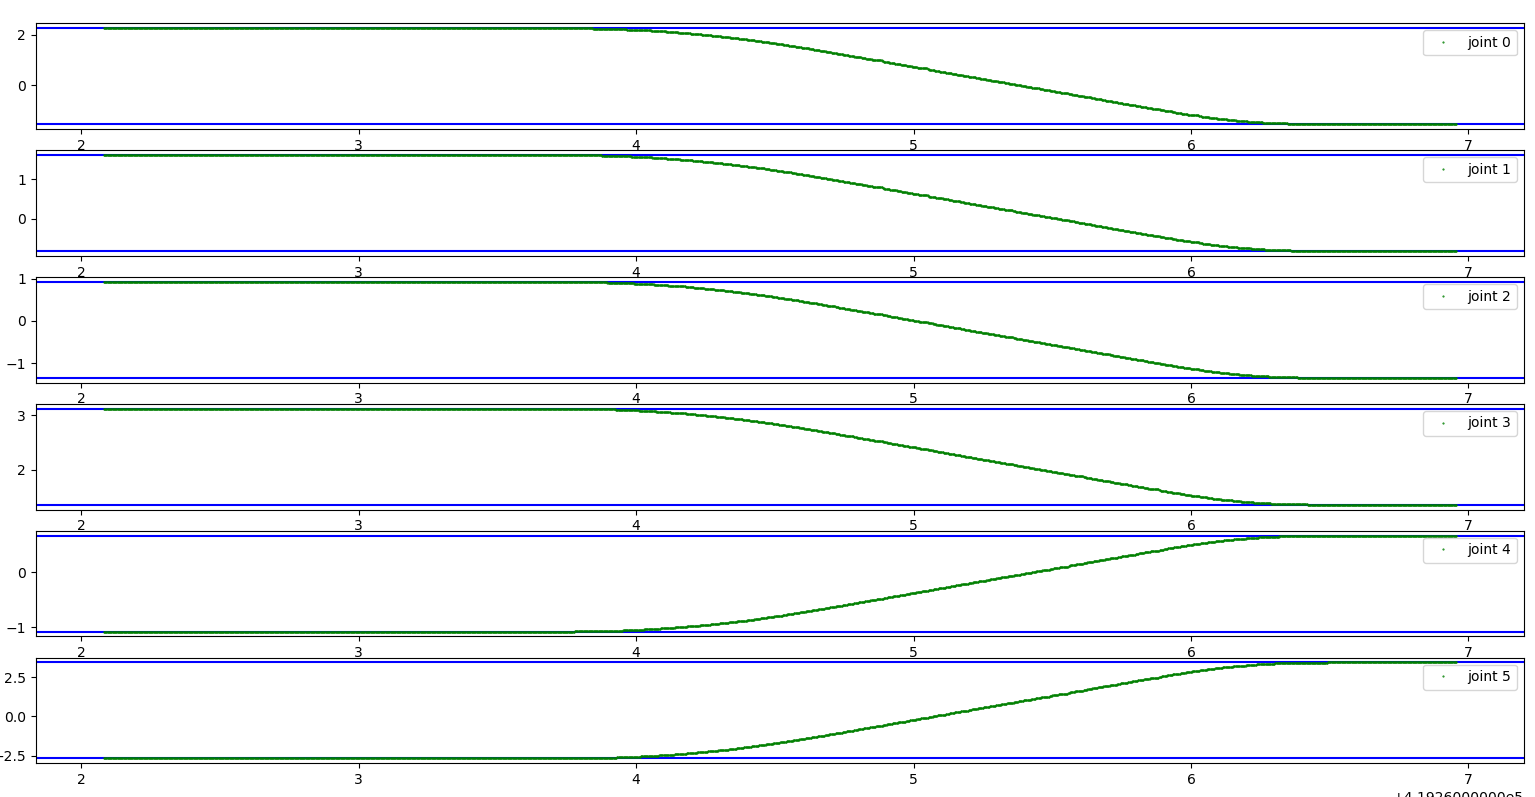

This above plots shows robot's joint configuration over time during a move. The blue horizontal bar marks when robot's actual position is close enough to the commanded start/end configuration. The duration of the motion is the time between any joint starts moving and all joints gets close enough to the target pose.

All 6000+ data files are processed and stored into a dataframe. Which is written into the `condensed_datas.json` file, and able to be de-serialized later for processing.

The structure of the data basically is 
* Start joint configs
* End joint configs
* Motion duration


## Backing Equation and Math

The dynamic equations of a robot is a known systems-equation. For example a simple 2-joint plainer robot have the following dynamics equations
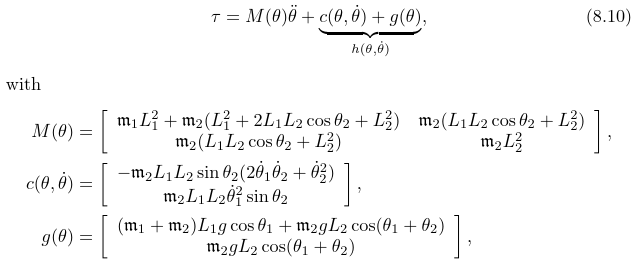

We can observe from this equation that the dynamic systems have lots of non-linear terms and is highly complex. The amount of parameter also scale up dramatically according to robot's joint number.

## Implementing the neural network  

All code are available in this github repo https://github.com/Gray-Stone/robotarm-movetime-guess

To achieve better performance, pytorch is used as it have good GPU support. 

The general workflow is as following: 
* Read the processed json files
* Convert data into pytorch's tensor format 
* Randomly split data into 80% training and 20% testing. 
* Select the neural network model to be used
* Start the training iteration. 
* For every iteration, also apply the model to test data to get a mean absolute error cost on current status. 

### Parameter choices

The training used stochastic gradient descent (SGD) as optimizer, and mean absolute error as cost function.

## Performance of different neural network design

### Pure linear

With pure linear model (without non-linear activation), it is obvious that it will not able to learn the model very well. Since it has no way of modeling the non-linear features in the system.

### Using only Tanh

When added Tanh activation between every linear layer, the performance of the model starting to get a lot better

The model is generally in the shape of
```
  (0): Linear(in_features=12, out_features=56, bias=True)
  (1): Tanh()
  (2): Linear(in_features=56, out_features=46, bias=True)
  (3): Tanh()
  (4): Linear(in_features=46, out_features=37, bias=True)
  (5): Tanh()
  (6): Linear(in_features=37, out_features=28, bias=True)
  (7): Tanh()
  (8): Linear(in_features=28, out_features=19, bias=True)
  (9): Tanh()
  (10): Linear(in_features=19, out_features=10, bias=True)
  (11): Tanh()
  (12): Linear(in_features=10, out_features=1, bias=True)
  (13): Tanh()
  (14): Linear(in_features=1, out_features=1, bias=True)
```

### Mixed in ReLU

The nature of ReLU model is squashing all input below 0. 

When switching out the last Activation layer to ReLU, the model perform equally well, in some case, this model converge quicker then the simple Tanh Model. This is likely due to the final output, which is motion duration is a positive number. Thus removing negative values at the end would help the model's accuracy.

```
  (17): Tanh()
  (18): Linear(in_features=15, out_features=10, bias=True)
  (19): ReLU()
  (20): Linear(in_features=10, out_features=1, bias=True)
```

### Mixing in other activation function

Many different models has been tried with other non-binary activation functions, like Leakly-ReLU and tanh-shrink. These doesn't make the model better then tanh, and usually start learning (converging) later then a simple tanh activated model.

### Best model so far

The best model so far is a model with ReLU activation at last layer, LeakyReLU near the beginning and tanh for the rest. 

This model is not the best in terms of how quickly does it start learning. However when it start converging, it dropped to a lower error very soon, and is able to kept the error lower the most other models. 

Other trials has been made with using only LeakyReLU or mixed LeakyReLU with Tanh. These all does poorly, either not able to learn at all or learning very slowly.

It is unknown why the LeakyRelu layer in the middle greatly improved the learning.

```
  (0): Linear(in_features=12, out_features=66, bias=True)
  (1): Tanh()
  (2): Linear(in_features=66, out_features=59, bias=True)
  (3): Tanh()
  (4): Linear(in_features=59, out_features=53, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=53, out_features=47, bias=True)
  (7): Tanh()
  (8): Linear(in_features=47, out_features=41, bias=True)
  (9): Tanh()
  (10): Linear(in_features=41, out_features=35, bias=True)
  (11): Tanh()
  (12): Linear(in_features=35, out_features=29, bias=True)
  (13): Tanh()
  (14): Linear(in_features=29, out_features=23, bias=True)
  (15): Tanh()
  (16): Linear(in_features=23, out_features=17, bias=True)
  (17): Tanh()
  (18): Linear(in_features=17, out_features=11, bias=True)
  (19): ReLU()
  (20): Linear(in_features=11, out_features=1, bias=True)
```

### Increasing depth or Width

Attempts has also been made with models having huge depth like 100 layers or huge width on first few layers like 300 nodes per layer. 

All of these attempts failed to generate any better then pure linear learning. The reason why such model failed could be due to the lack of data. Since the number of parameters increase dramatically with the depth of the model. There might not be enough data point for all these parameters. 



## A comparison between different models.

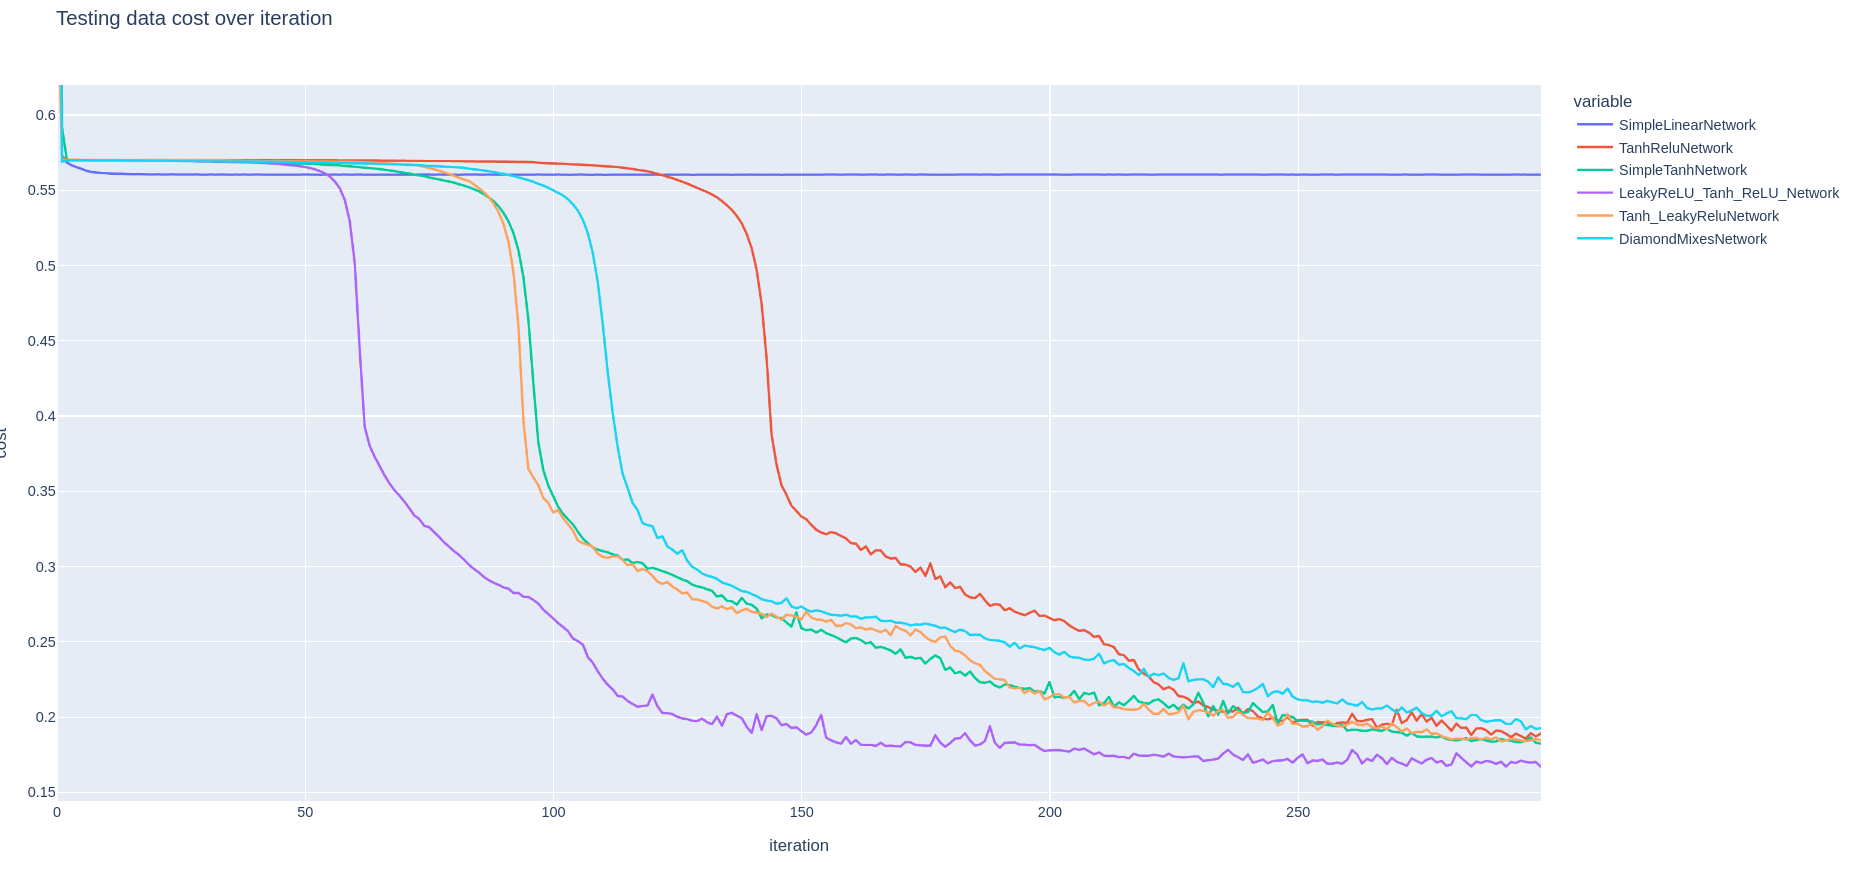


## Manipulating Input

Normalizing and adding feature functions to input is a common method used to help fitting the model. Two attempts are made here. 

### Normalizing Input 

Since input are a list of robot joint configs, We can be sure the values will not be outside of its joint limit.

A attempt is made to scale all joints down with a factor of 6, since most robot's joint limit is +-2pi, which is close to 6. 

This method did not provided any positive impact. This might be due to the output not being normalized. However it's hard to know a cap for the output motion duration, thus not attempted.

### Increasing input dimension 

Since it matter for the length of the move (geometrically). A attempt is made to increase the input dimension from 12 (6 joint robot) to 18, with the extra 6 dimensions being the (start_config - end_config) for each joint. 

This method also did not have any positive impact. The reason might be with added feature, now the amount of data becomes in-sufficient. 

## Conclusion 

The above finding shows that using machine learning to predict the output of a time-optimized industrial robot's motion is totally possible. However the design of the model needs some better choice and might need a lot more data to provide an accurate model. 



## Appendix 

The stack up for each model used is as following 

```
SimpleLinearNetwork
Sequential(
  (0): Linear(in_features=12, out_features=24, bias=True)
  (1): Linear(in_features=24, out_features=18, bias=True)
  (2): Linear(in_features=18, out_features=8, bias=True)
  (3): Linear(in_features=8, out_features=1, bias=True)
)

TanhReluNetwork
Sequential(
  (0): Linear(in_features=12, out_features=56, bias=True)
  (1): Tanh()
  (2): Linear(in_features=56, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=45, bias=True)
  (5): Tanh()
  (6): Linear(in_features=45, out_features=40, bias=True)
  (7): Tanh()
  (8): Linear(in_features=40, out_features=35, bias=True)
  (9): Tanh()
  (10): Linear(in_features=35, out_features=30, bias=True)
  (11): Tanh()
  (12): Linear(in_features=30, out_features=25, bias=True)
  (13): Tanh()
  (14): Linear(in_features=25, out_features=20, bias=True)
  (15): Tanh()
  (16): Linear(in_features=20, out_features=15, bias=True)
  (17): Tanh()
  (18): Linear(in_features=15, out_features=10, bias=True)
  (19): ReLU()
  (20): Linear(in_features=10, out_features=1, bias=True)
)

SimpleTanhNetwork
Sequential(
  (0): Linear(in_features=12, out_features=56, bias=True)
  (1): Tanh()
  (2): Linear(in_features=56, out_features=46, bias=True)
  (3): Tanh()
  (4): Linear(in_features=46, out_features=37, bias=True)
  (5): Tanh()
  (6): Linear(in_features=37, out_features=28, bias=True)
  (7): Tanh()
  (8): Linear(in_features=28, out_features=19, bias=True)
  (9): Tanh()
  (10): Linear(in_features=19, out_features=10, bias=True)
  (11): Tanh()
  (12): Linear(in_features=10, out_features=1, bias=True)
  (13): Tanh()
  (14): Linear(in_features=1, out_features=1, bias=True)
)

LeakyReLU_Tanh_ReLU_Network
Sequential(
  (0): Linear(in_features=12, out_features=66, bias=True)
  (1): Tanh()
  (2): Linear(in_features=66, out_features=59, bias=True)
  (3): Tanh()
  (4): Linear(in_features=59, out_features=53, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=53, out_features=47, bias=True)
  (7): Tanh()
  (8): Linear(in_features=47, out_features=41, bias=True)
  (9): Tanh()
  (10): Linear(in_features=41, out_features=35, bias=True)
  (11): Tanh()
  (12): Linear(in_features=35, out_features=29, bias=True)
  (13): Tanh()
  (14): Linear(in_features=29, out_features=23, bias=True)
  (15): Tanh()
  (16): Linear(in_features=23, out_features=17, bias=True)
  (17): Tanh()
  (18): Linear(in_features=17, out_features=11, bias=True)
  (19): ReLU()
  (20): Linear(in_features=11, out_features=1, bias=True)
)

Tanh_LeakyReluNetwork
Sequential(
  (0): Linear(in_features=12, out_features=56, bias=True)
  (1): Tanh()
  (2): Linear(in_features=56, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=45, bias=True)
  (5): Tanh()
  (6): Linear(in_features=45, out_features=40, bias=True)
  (7): Tanh()
  (8): Linear(in_features=40, out_features=35, bias=True)
  (9): Tanh()
  (10): Linear(in_features=35, out_features=30, bias=True)
  (11): Tanh()
  (12): Linear(in_features=30, out_features=25, bias=True)
  (13): Tanh()
  (14): Linear(in_features=25, out_features=20, bias=True)
  (15): Tanh()
  (16): Linear(in_features=20, out_features=15, bias=True)
  (17): Tanh()
  (18): Linear(in_features=15, out_features=10, bias=True)
  (19): LeakyReLU(negative_slope=0.01)
  (20): Linear(in_features=10, out_features=1, bias=True)
)

DiamondMixesNetwork
Sequential(
  (0): Linear(in_features=12, out_features=33, bias=True)
  (1): Tanh()
  (2): Linear(in_features=33, out_features=55, bias=True)
  (3): Tanh()
  (4): Linear(in_features=55, out_features=76, bias=True)
  (5): Tanh()
  (6): Linear(in_features=76, out_features=98, bias=True)
  (7): Tanh()
  (8): Linear(in_features=98, out_features=79, bias=True)
  (9): Tanh()
  (10): Linear(in_features=79, out_features=60, bias=True)
  (11): Tanh()
  (12): Linear(in_features=60, out_features=41, bias=True)
  (13): Tanh()
  (14): Linear(in_features=41, out_features=22, bias=True)
  (15): Tanh()
  (16): Linear(in_features=22, out_features=3, bias=True)
  (17): Tanh()
  (18): Linear(in_features=3, out_features=1, bias=True)
)


```